<a href="https://colab.research.google.com/github/Pallav-Lama/deeplearning-projects/blob/main/Age_Gender_Ethnicity_using_Functional_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

 97% 320M/331M [00:02<00:00, 197MB/s]
100% 331M/331M [00:02<00:00, 144MB/s]


In [ ]:
import zipfile
zip = zipfile.ZipFile('/content/utkface-new.zip')
zip.extractall("/content")
zip.close()

In [ ]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
folder_path = '/content/utkface_aligned_cropped/UTKFace'

In [ ]:
age = []
gender = []
ethnicity = []
img_path = []
for file in os.listdir(folder_path):
  splitted = file.split('_')
  age.append(int(splitted[0]))
  gender.append(int(splitted[1]))
  try:
    ethnicity.append(int(splitted[2]))
  except:
    ethnicity.append(splitted[2])
  img_path.append(file)

In [ ]:
splitted

['51', '1', '0', '20170110125229594.jpg.chip.jpg']

In [ ]:
len(age)

23708

In [ ]:
len(gender)

23708

In [ ]:
len(ethnicity)

23708

In [ ]:
len(img_path)

23708

In [ ]:
df = pd.DataFrame({'age': age, 'gender':gender, 'ethnicity': ethnicity, 'img': img_path})
df.head()

,age,gender,ethnicity,img
0,53,0,0,53_0_0_20170120223133507.jpg.chip.jpg
1,17,1,0,17_1_0_20170117140619087.jpg.chip.jpg
2,32,0,3,32_0_3_20170119200348476.jpg.chip.jpg
3,4,1,0,4_1_0_20170117201312381.jpg.chip.jpg
4,90,1,2,90_1_2_20170111221639268.jpg.chip.jpg


In [ ]:
df.drop(df[df.ethnicity.str.isdigit() == False].index, inplace = True)

In [ ]:
len(df.ethnicity.unique())

5

In [ ]:
df.head()

,age,gender,ethnicity,img
0,53,0,0,53_0_0_20170120223133507.jpg.chip.jpg
1,17,1,0,17_1_0_20170117140619087.jpg.chip.jpg
2,32,0,3,32_0_3_20170119200348476.jpg.chip.jpg
3,4,1,0,4_1_0_20170117201312381.jpg.chip.jpg
4,90,1,2,90_1_2_20170111221639268.jpg.chip.jpg


In [ ]:
train_df = df.sample(frac = 1, random_state = 42).iloc[:20000]
test_df = df.sample(frac = 1, random_state = 42).iloc[20000:]

In [ ]:
train_df.shape

(20000, 4)

In [ ]:
test_df.shape

(3705, 4)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory = folder_path,
                                                    x_col = 'img',
                                                    y_col = ['age','gender', 'ethnicity'],
                                                    target_size = (200, 200),
                                                    class_mode = 'multi_output'

                                                    )
test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    directory = folder_path,
                                                    x_col = 'img',
                                                    y_col = ['age','gender', 'ethnicity'],
                                                    target_size = (200, 200),
                                                    class_mode = 'multi_output'
                                                    )

Found 20000 validated image filenames.
Found 3705 validated image filenames.


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model

In [ ]:
vggnet = VGG16(include_top = False, input_shape = (200, 200, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
vggnet.trainable = False

output = vggnet.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512, activation = 'relu')(flatten)
dense2 = Dense(512, activation = 'relu')(flatten)
dense3 = Dense(512, activation = 'relu')(flatten)

dense4 = Dense(512, activation = 'relu')(dense1)
dense5 = Dense(512, activation = 'relu')(dense2)
dense6 = Dense(512, activation = 'relu')(dense3)

dense7 = Dense(256, activation = 'relu')(dense6)
dense8 = Dense(64, activation = 'relu')(dense7)

output1 = Dense(1, activation = 'linear', name ='age')(dense4)
output2 = Dense(1, activation ='sigmoid', name= 'gender')(dense5)
output3 = Dense(5, activation = 'softmax', name ='ethnicity')(dense8)

In [ ]:
model = Model(inputs = vggnet.input, outputs = [output1, output2, output3])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 200, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 200, 200, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

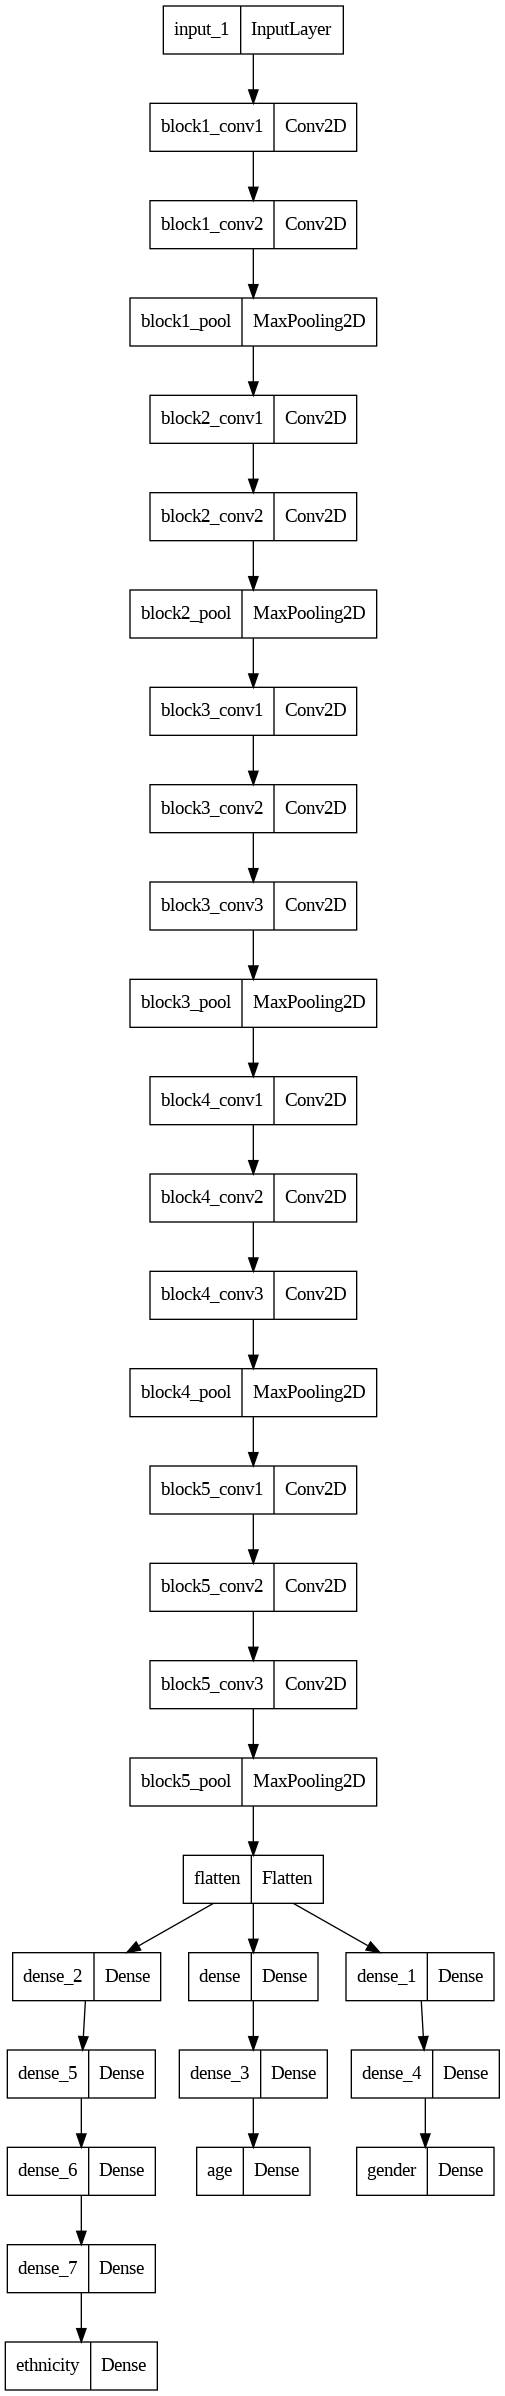

In [ ]:
from keras.utils import plot_model
plot_model(model)

In [ ]:
model.compile(optimizer = 'adam', loss ={'age': 'mae', 'gender': 'binary_crossentropy', 'ethnicity': 'sparse_categorical_crossentropy'}, metrics ={'age': 'mae', 'gender': 'accuracy', 'ethnicity': 'accuracy'})

In [ ]:
history = model.fit(train_generator, batch_size = 32, epochs = 10, validation_data = test_generator)

Epoch 1/10
625/625 [==============================] - 244s 366ms/step - loss: 12.6933 - age_loss: 10.9429 - gender_loss: 0.5387 - ethnicity_loss: 1.2118 - age_mae: 10.9429 - gender_accuracy: 0.7406 - ethnicity_accuracy: 0.5340 - val_loss: 10.9192 - val_age_loss: 9.5645 - val_gender_loss: 0.3644 - val_ethnicity_loss: 0.9904 - val_age_mae: 9.5645 - val_gender_accuracy: 0.8340 - val_ethnicity_accuracy: 0.6345
Epoch 2/10
625/625 [==============================] - 224s 359ms/step - loss: 10.9053 - age_loss: 9.3990 - gender_loss: 0.4420 - ethnicity_loss: 1.0642 - age_mae: 9.3990 - gender_accuracy: 0.7913 - ethnicity_accuracy: 0.6000 - val_loss: 9.7080 - val_age_loss: 8.3820 - val_gender_loss: 0.3512 - val_ethnicity_loss: 0.9748 - val_age_mae: 8.3820 - val_gender_accuracy: 0.8410 - val_ethnicity_accuracy: 0.6413
Epoch 3/10
625/625 [==============================] - 224s 358ms/step - loss: 10.5036 - age_loss: 9.0653 - gender_loss: 0.4102 - ethnicity_loss: 1.0282 - age_mae: 9.0653 - gender_accu

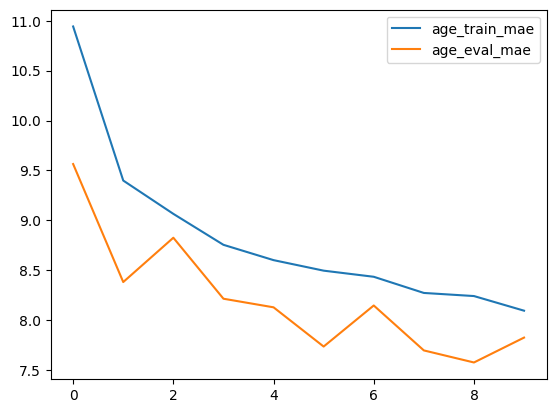

In [ ]:
import matplotlib.pyplot as plt
epoch = history.epoch

#Age
age_train_mae = history.history['age_mae']
age_eval_mae = history.history['val_age_mae']

#mae
plt.plot(epoch, age_train_mae, label = 'age_train_mae')
plt.plot(epoch, age_eval_mae, label = 'age_eval_mae')
plt.legend()

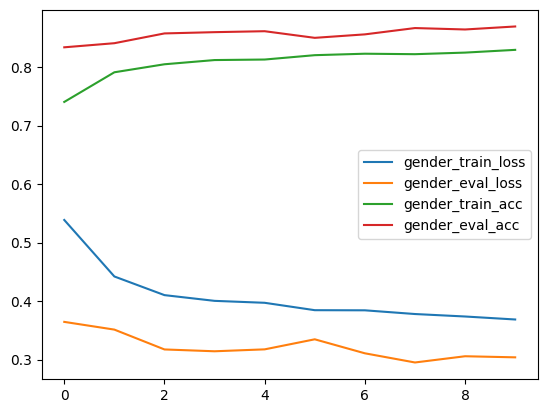

In [ ]:
#Gender
gender_train_loss = history.history['gender_loss']
gender_eval_loss = history.history['val_gender_loss']

gender_train_acc = history.history['gender_accuracy']
gender_eval_acc = history.history['val_gender_accuracy']
plt.plot(epoch, gender_train_loss, label = 'gender_train_loss')
plt.plot(epoch, gender_eval_loss, label = 'gender_eval_loss')
plt.plot(epoch, gender_train_acc, label = 'gender_train_acc')
plt.plot(epoch, gender_eval_acc, label = 'gender_eval_acc')
plt.legend()

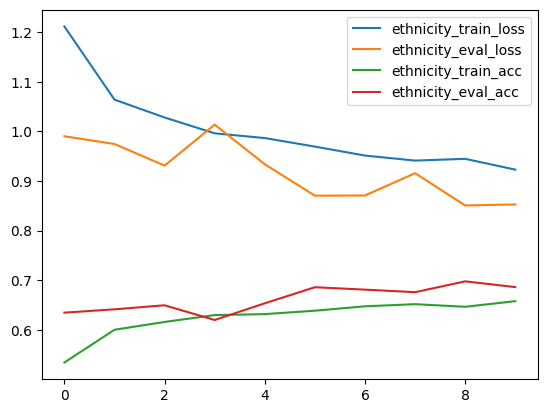

In [ ]:
#ethnicity
ethnicity_train_loss = history.history['ethnicity_loss']
ethnicity_eval_loss = history.history['val_ethnicity_loss']

ethnicity_train_acc = history.history['ethnicity_accuracy']
ethnicity_eval_acc = history.history['val_ethnicity_accuracy']
#mae
plt.plot(epoch, ethnicity_train_loss, label = 'ethnicity_train_loss')
plt.plot(epoch, ethnicity_eval_loss, label = 'ethnicity_eval_loss')
plt.plot(epoch, ethnicity_train_acc, label = 'ethnicity_train_acc')
plt.plot(epoch, ethnicity_eval_acc, label = 'ethnicity_eval_acc')
plt.legend()

In [ ]:
!wget https://img.freepik.com/free-photo/senior-woman-hospital-patient-cured-from-covid-19_53876-148033.jpg

--2023-06-05 04:53:39--  https://img.freepik.com/free-photo/senior-woman-hospital-patient-cured-from-covid-19_53876-148033.jpg
Resolving img.freepik.com (img.freepik.com)... 23.192.24.108, 2600:1408:c400:187::312e, 2600:1408:c400:18a::312e
Connecting to img.freepik.com (img.freepik.com)|23.192.24.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41325 (40K) [image/jpeg]
Saving to: ‘senior-woman-hospital-patient-cured-from-covid-19_53876-148033.jpg’

senior-woman-hospit 100%[===================>]  40.36K  --.-KB/s    in 0.09s   

2023-06-05 04:53:40 (464 KB/s) - ‘senior-woman-hospital-patient-cured-from-covid-19_53876-148033.jpg’ saved [41325/41325]



In [ ]:
import cv2
image = cv2.imread('/content/senior-woman-hospital-patient-cured-from-covid-19_53876-148033.jpg')
image.shape

(501, 626, 3)

In [ ]:
reshaped_image = cv2.resize(image, (200, 200))

In [ ]:
reshaped_image.shape

(200, 200, 3)

In [ ]:
import numpy as np
batched_image = np.expand_dims(reshaped_image, axis = 0)

In [ ]:
batched_image.shape

(1, 200, 200, 3)

In [ ]:
age, gender, ethnicity = model.predict(batched_image)

1/1 [==============================] - 0s 33ms/step


In [ ]:
age

array([[81.82986]], dtype=float32)

In [ ]:
gender

array([[1.2331675e-32]], dtype=float32)

In [ ]:
ethnicity = np.argmax(ethnicity)

In [ ]:
ethnicity

1

In [ ]:
ethnic_class = ['White', "Black", 'Asian', 'Indian', 'Others']

In [ ]:
gender_class = ['Male', 'Female']

In [ ]:
def predict_face(image):
  reshaped_image = cv2.resize(image, (200, 200))
  batched_image = np.expand_dims(reshaped_image, axis = 0)
  age, gender, ethnicity = model.predict(batched_image)
  plt.imshow(image)
  age, gender, ethnicity = model.predict(batched_image)
  ethnicity = ethnic_class[np.argmax(ethnicity)]
  if gender < 0.5:
    gender_class = 'Male'
  else:
    gender_class = "Female"
  plt.title(f'Age: {age[0][0]}, Gender: {gender_class}, Ethnicity: {ethnicity}')
  plt.axis('off')

In [ ]:
!wget https://img.freepik.com/free-photo/asian-man-isolated-expressing-emotions_1303-26709.jpg

--2023-06-05 05:12:36--  https://img.freepik.com/free-photo/asian-man-isolated-expressing-emotions_1303-26709.jpg
Resolving img.freepik.com (img.freepik.com)... 23.192.24.108, 2600:1408:c400:187::312e, 2600:1408:c400:18a::312e
Connecting to img.freepik.com (img.freepik.com)|23.192.24.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31205 (30K) [image/jpeg]
Saving to: ‘asian-man-isolated-expressing-emotions_1303-26709.jpg’

asian-man-isolated- 100%[===================>]  30.47K  --.-KB/s    in 0.09s   

2023-06-05 05:12:36 (349 KB/s) - ‘asian-man-isolated-expressing-emotions_1303-26709.jpg’ saved [31205/31205]



In [ ]:
img = cv2.imread('/content/asian-man-isolated-expressing-emotions_1303-26709.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

1/1 [==============================] - 0s 28ms/step


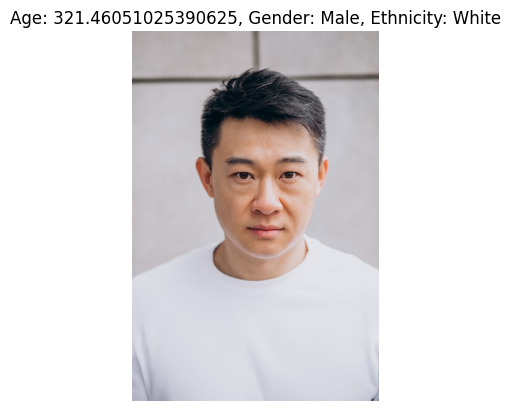

In [ ]:
predict_face(img)

In [ ]:
!wget https://img.freepik.com/free-photo/serious-young-african-man-standing-isolated_171337-9633.jpg

--2023-06-05 05:17:34--  https://img.freepik.com/free-photo/serious-young-african-man-standing-isolated_171337-9633.jpg
Resolving img.freepik.com (img.freepik.com)... 23.77.172.248, 2600:1408:c400:187::312e, 2600:1408:c400:18a::312e
Connecting to img.freepik.com (img.freepik.com)|23.77.172.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29864 (29K) [image/jpeg]
Saving to: ‘serious-young-african-man-standing-isolated_171337-9633.jpg’

serious-young-afric 100%[===================>]  29.16K  --.-KB/s    in 0.1s    

2023-06-05 05:17:35 (230 KB/s) - ‘serious-young-african-man-standing-isolated_171337-9633.jpg’ saved [29864/29864]



In [ ]:
img = cv2.imread('/content/serious-young-african-man-standing-isolated_171337-9633.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

1/1 [==============================] - 0s 29ms/step


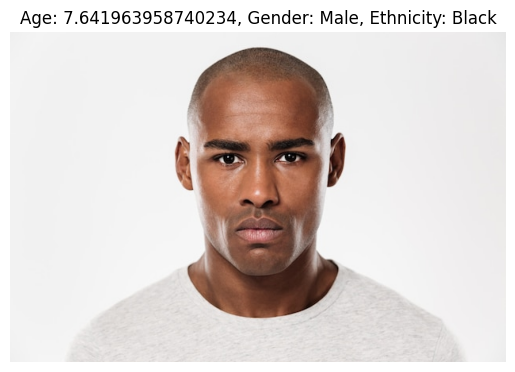

In [ ]:
predict_face(img)